In [63]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import shapely as shp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
import os

# 2) Load the ClimEx ForeFire runs

In [64]:
regions = ['North', 'Central', 'South']
scenarios = ['era5-land', 'ssp1', 'ssp2', 'ssp3'] # to add ssp2
common_path = r'O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\IIASA-results'


all_gdfs = []

for region in regions:
    region_path = os.path.join(common_path, region)
    print(f"Processing region: {region}")

    for scenario in scenarios:
        scenario_files = glob.glob(os.path.join(region_path, '**', f'*{scenario}*.shp'), recursive=True)

        print(f"  Scenario: {scenario}, found {len(scenario_files)} shapefiles")

        for f in scenario_files:
            gdf = gpd.read_file(f)

            # Ensure 'date' column is datetime
            gdf['date'] = pd.to_datetime(gdf['date'], errors='coerce')
            gdf['year'] = gdf['date'].dt.year

            # Add metadata
            gdf['scenario'] = scenario
            gdf['region'] = region
    

            # Select only needed columns
            gdf = gdf[['date', 'year', 'area_ha', 'scenario', 'region']]
            all_gdfs.append(gdf)

# Combine all scenario-region dataframes into one
all_fires_regions_scenarios = pd.concat(all_gdfs, ignore_index=True)


Processing region: North
  Scenario: era5-land, found 1 shapefiles
  Scenario: ssp1, found 4 shapefiles
  Scenario: ssp2, found 4 shapefiles
  Scenario: ssp3, found 4 shapefiles
Processing region: Central
  Scenario: era5-land, found 1 shapefiles
  Scenario: ssp1, found 4 shapefiles
  Scenario: ssp2, found 4 shapefiles
  Scenario: ssp3, found 4 shapefiles
Processing region: South
  Scenario: era5-land, found 1 shapefiles
  Scenario: ssp1, found 4 shapefiles
  Scenario: ssp2, found 4 shapefiles
  Scenario: ssp3, found 4 shapefiles


In [65]:
all_fires_regions_scenarios['period'] = None
all_fires_regions_scenarios.loc[(all_fires_regions_scenarios['year'] >= 1991) & (all_fires_regions_scenarios['year'] <= 2010), 'period'] = '1991-2010'
all_fires_regions_scenarios.loc[(all_fires_regions_scenarios['year'] >= 2021) & (all_fires_regions_scenarios['year'] <= 2040), 'period'] = '2021-2040'
all_fires_regions_scenarios.loc[(all_fires_regions_scenarios['year'] >= 2041) & (all_fires_regions_scenarios['year'] <= 2060), 'period'] = '2041-2060'
all_fires_regions_scenarios.loc[(all_fires_regions_scenarios['year'] >= 2061) & (all_fires_regions_scenarios['year'] <= 2080), 'period'] = '2061-2080'
all_fires_regions_scenarios.loc[(all_fires_regions_scenarios['year'] >= 2081) & (all_fires_regions_scenarios['year'] <= 2100), 'period'] = '2081-2100'

all_fires_regions_scenarios

,date,year,area_ha,scenario,region,period
0,2014-07-30,2014,119.840000,era5-land,North,None
1,2014-07-10,2014,40.220000,era5-land,North,None
2,2018-07-16,2018,70.620000,era5-land,North,None
3,2018-07-12,2018,51.640000,era5-land,North,None
4,2018-07-19,2018,163.110000,era5-land,North,None
...,...,...,...,...,...,...
319927,2046-09-10,2046,159.383907,ssp3,South,2041-2060
319928,2041-07-29,2041,385.878888,ssp3,South,2041-2060
319929,2052-08-16,2052,227.578557,ssp3,South,2041-2060
319930,2048-07-02,2048,97.013923,ssp3,South,2041-2060


In [66]:
# group them by year and scenario
all_fires_scenarios = all_fires_regions_scenarios.groupby(['year', 'scenario', 'period', 'region'])['area_ha'].sum().reset_index()
all_fires_scenarios['area_km2'] = all_fires_scenarios['area_ha'] / 100  # Convert to km²
all_fires_scenarios

,year,scenario,period,region,area_ha,area_km2
0,2008,era5-land,1991-2010,Central,78734.990000,787.349900
1,2008,era5-land,1991-2010,South,317413.990000,3174.139900
2,2009,era5-land,1991-2010,Central,47763.020000,477.630200
3,2009,era5-land,1991-2010,South,336075.050000,3360.750500
4,2010,era5-land,1991-2010,Central,25885.530000,258.855300
...,...,...,...,...,...,...
667,2100,ssp2,2081-2100,North,8550.075884,85.500759
668,2100,ssp2,2081-2100,South,644699.757294,6446.997573
669,2100,ssp3,2081-2100,Central,109514.150000,1095.141500
670,2100,ssp3,2081-2100,North,8285.820000,82.858200


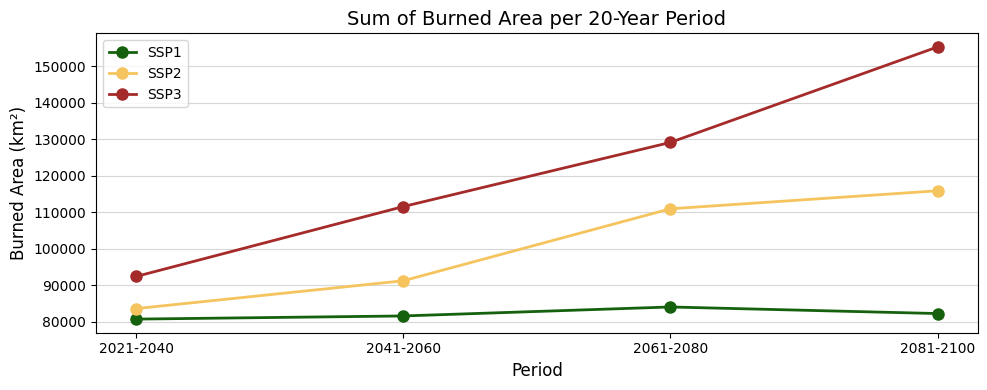

In [72]:
# Filter scenarios

total_ssp1 = all_fires_scenarios[all_fires_scenarios['scenario'] == 'ssp1']
total_ssp2 = all_fires_scenarios[all_fires_scenarios['scenario'] == 'ssp2']
total_ssp3 = all_fires_scenarios[all_fires_scenarios['scenario'] == 'ssp3']

# Group and compute mean burned area per period
ssp1_means = total_ssp1.groupby('period')['area_km2'].sum().reindex(['2021-2040', '2041-2060', '2061-2080', '2081-2100'])
ssp2_means = total_ssp2.groupby('period')['area_km2'].sum().reindex(['2021-2040', '2041-2060', '2061-2080', '2081-2100'])
ssp3_means = total_ssp3.groupby('period')['area_km2'].sum().reindex(['2021-2040', '2041-2060', '2061-2080', '2081-2100'])
# Plot
fig, ax = plt.subplots(figsize=(10, 4))

periods = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
ax.plot(periods, ssp1_means, color='#16610E', marker='o', linestyle='-', linewidth=2, markersize=8, label='SSP1')
ax.plot(periods, ssp2_means, color='#F5C45E', marker='o', linestyle='-', linewidth=2, markersize=8, label='SSP2')
ax.plot(periods, ssp3_means, color='#A52A2A', marker='o', linestyle='-', linewidth=2, markersize=8, label='SSP3')


# Labels and title
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Burned Area (km²)', fontsize=12)
ax.set_title('Sum of Burned Area per 20-Year Period', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [68]:
all_fires_regions_scenarios

,date,year,area_ha,scenario,region,period
0,2014-07-30,2014,119.840000,era5-land,North,None
1,2014-07-10,2014,40.220000,era5-land,North,None
2,2018-07-16,2018,70.620000,era5-land,North,None
3,2018-07-12,2018,51.640000,era5-land,North,None
4,2018-07-19,2018,163.110000,era5-land,North,None
...,...,...,...,...,...,...
319927,2046-09-10,2046,159.383907,ssp3,South,2041-2060
319928,2041-07-29,2041,385.878888,ssp3,South,2041-2060
319929,2052-08-16,2052,227.578557,ssp3,South,2041-2060
319930,2048-07-02,2048,97.013923,ssp3,South,2041-2060


C:\Users\jsoma\AppData\Local\Temp\ipykernel_18628\3770567311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical.sort_values(by='date', inplace=True)
C:\Users\jsoma\AppData\Local\Temp\ipykernel_18628\3770567311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssp1.sort_values(by='date', inplace=True)
C:\Users\jsoma\AppData\Local\Temp\ipykernel_18628\3770567311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssp2.sort_

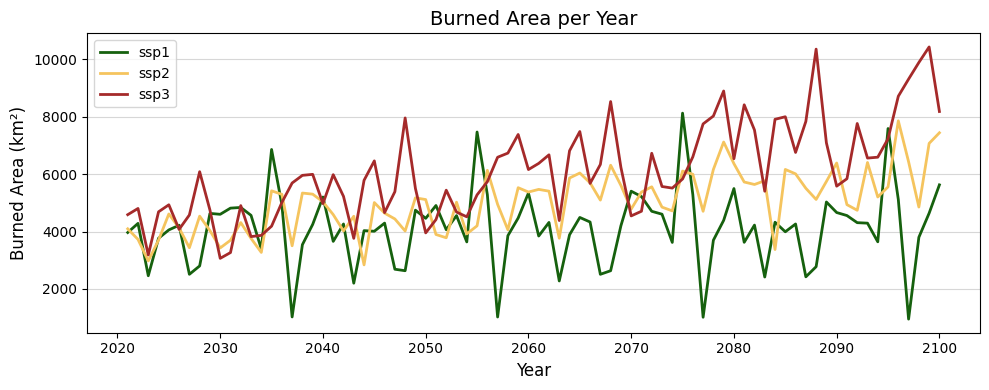

In [73]:
historical = all_fires_regions_scenarios[all_fires_regions_scenarios['scenario'] == 'era5-land']
historical.sort_values(by='date', inplace=True)
ssp1 = all_fires_regions_scenarios[all_fires_regions_scenarios['scenario'] == 'ssp1']
ssp1.sort_values(by='date', inplace=True)
ssp2 = all_fires_regions_scenarios[all_fires_regions_scenarios['scenario'] == 'ssp2']
ssp2.sort_values(by='date', inplace=True)
ssp3 = all_fires_regions_scenarios[all_fires_regions_scenarios['scenario'] == 'ssp3']
ssp3.sort_values(by='date', inplace=True)

# sum all the area by year
historical_yearly = historical.groupby('year')['area_ha'].sum().reset_index()
historical_yearly['area_km2'] = historical_yearly['area_ha'] / 100  # Convert to km²
ssp1_yearly = ssp1.groupby('year')['area_ha'].sum().reset_index()
ssp1_yearly['area_km2'] = ssp1_yearly['area_ha'] / 100  # Convert to km²
ssp2_yearly = ssp2.groupby('year')['area_ha'].sum().reset_index()
ssp2_yearly['area_km2'] = ssp2_yearly['area_ha'] / 100  # Convert to km²
ssp3_yearly = ssp3.groupby('year')['area_ha'].sum().reset_index()
ssp3_yearly['area_km2'] = ssp3_yearly['area_ha'] / 100  # Convert to km²

bar_width = 1

# plot the yearly data
fig, ax = plt.subplots(figsize=(10, 4))
# Plot lines
# ax.plot(historical_yearly['year'], historical_yearly['area_km2'], color='#000000', linestyle='-', linewidth=2, markersize=5, label='Era5-Land')
ax.plot(ssp1_yearly['year'], ssp1_yearly['area_km2'], color='#16610E', linestyle='-', linewidth=2, markersize=5, label='ssp1')
ax.plot(ssp2_yearly['year'], ssp2_yearly['area_km2'], color='#F5C45E', linestyle='-', linewidth=2, markersize=5, label='ssp2')
ax.plot(ssp3_yearly['year'], ssp3_yearly['area_km2'], color='#A52A2A', linestyle='-', linewidth=2, markersize=5, label='ssp3')

# Labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Burned Area (km²)', fontsize=12)
ax.set_title('Burned Area per Year', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()